In [1]:
# %load /Users/dsuess/Code/Pythonlibs/parallel.ipy
import ipyparallel
_clients = ipyparallel.Client()
_view = _clients.load_balanced_view()
print("Kernels available: {}".format(len(_clients)))


Kernels available: 4


In [40]:
import numpy as np
import matplotlib.pyplot as pl
import cvxpy as cvx

import sys
sys.path.append('/Users/dsuess/Code/Pythonlibs/')
from tools.helpers import Progress
from tools.plot import matshow

In [3]:
def create_01_matrix(rows, cols, p=.5, rgen=np.random):
    mat = rgen.choice([0, 1], size=(rows, cols), p=(1 - p, p))
    return mat

def random_sparse_vector(dim, nnz, rgen=np.random):
    """Create a random sparse vector of dimension `dim` 
    with `nnz` nonzero elements """
    idx = rgen.choice(np.arange(dim), size=nnz, replace=False)
    result = np.zeros(dim)
    result[idx] = rgen.randn(nnz)
    return result

In [4]:
def l2_recover(A, y, sparsity=None):
    dim = A.shape[1]
    x_hat = cvx.Variable(dim)
    
    objective = cvx.Minimize(cvx.norm2(y - A*x_hat)**2)
    constraints = [x_hat >= 0]
    if sparsity is not None:
        constraints += [np.ones(dim) * x_hat <= sparsity]
    problem = cvx.Problem(objective, constraints)
    r = problem.solve()
    return r, np.ravel(x_hat.value)

In [5]:
def likelihood(a, x_obs, y_obs):
    rho = norm(scale=SIGMA).pdf
    return rho(vec_to_poly(a)(x_obs) - y_obs)

def aic(x, y, a):
    L = likelihood(a, x, y)
    return 2 * (len(a) - sum(np.log(L)))

def aicc(x, y, a):
    n = len(x)
    k = len(a)
    return aic(x, y, a) + 2*k*(k+1) / (n - k - 1)

def bic(x, y, a):
    return len(a) * np.log(len(x)) - 2 * sum(np.log(likelihood(a, x, y)))

100% (199 of 199) |#######################| Elapsed Time: 0:00:11 Time: 0:00:11


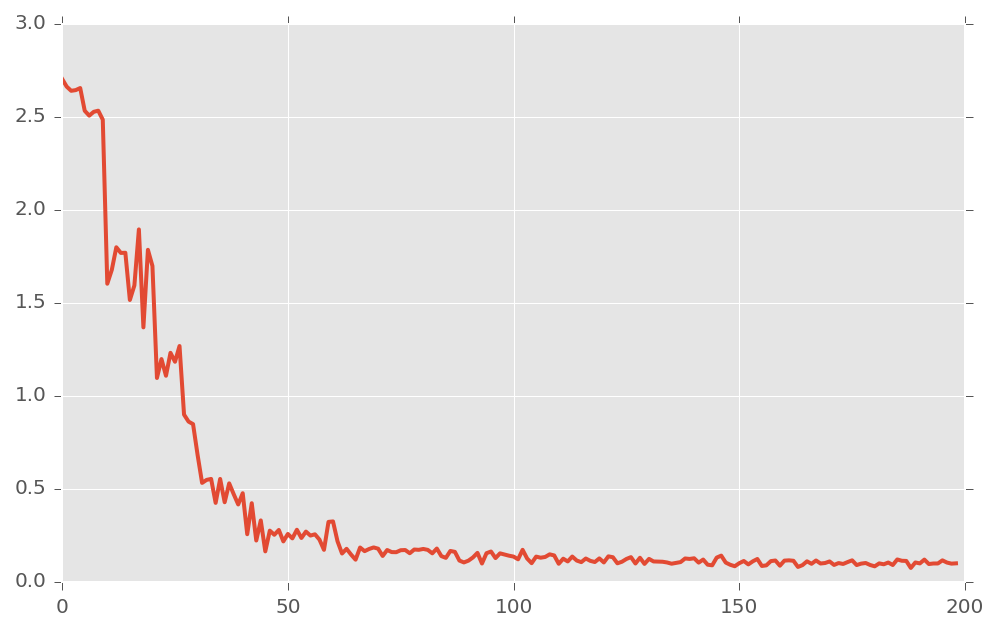

In [123]:
N = 200
R = 10
SIGMA = .1

x = np.abs(random_sparse_vector(N, R))
A = create_01_matrix(N, N)

x_hats = []
for M in Progress(range(1, N)):
    y = A[:M] @ x + SIGMA * np.random.randn(M)

    _, x_hat = l2_recover(A[:M], y)
    x_hats.append(x_hat)

In [129]:
import scipy.stats as st

M = 80
N = 400
R = 5
SIGMA = .001 / M
SAMPLES = 100


for R in [5, 10, 15]:
    rss = []
 
    for _ in range(5):
        A = create_01_matrix(M, N)
        x = np.abs(random_sparse_vector(N, R))
        x /= np.linalg.norm(x)
        rs = np.array([l2_recover(A, A @ x + SIGMA * np.random.randn(M))[0]
                       for _ in Progress(range(SAMPLES))])
        rs /= SIGMA**2
        rss.append(rs)

    for r in sorted(rss, key=lambda x: np.mean(x)):
        print(np.mean(r), end=" ")

    print("")

    for r in sorted(rss, key=lambda x: np.mean(x)):
        mean = np.mean(r)
        var = np.var(r)
        print(kstest(r, st.norm(mean, np.sqrt(var)).cdf).pvalue, end=" ")

100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:07 Time: 0:00:07
100% (100 of 100) |#######################| Elapsed Time: 0:00:07 Time: 0:00:07
  3% (  3 of 100) |                       | Elapsed Time: 0:00:00 ETA:  0:00:08

48.5113743687 51.3440275998 53.8765617674 54.4901647635 54.869022547 
0.786890253531 0.995640545674 0.478063457174 0.91663567182 0.996917134532 

100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
  3% (  3 of 100) |                       | Elapsed Time: 0:00:00 ETA:  0:00:07

28.109851131 28.6336676763 34.2365062698 37.7603679228 38.7434200702 
0.77023730706 0.855154277533 0.293671098353 0.79325786839 0.411490776185 

100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08
100% (100 of 100) |#######################| Elapsed Time: 0:00:07 Time: 0:00:07
 99% ( 99 of 100) |###################### | Elapsed Time: 0:00:08 ETA:  0:00:06

17.1175817894 21.3877618633 21.6120452005 24.8845188099 27.856031028 
0.834912013208 0.319978286995 0.83159794608 0.208219856821 0.402564892739 

100% (100 of 100) |#######################| Elapsed Time: 0:00:08 Time: 0:00:08


In [35]:
from scipy.stats import chi2, kstest
    
def model_to_f(model):
    pdf = lambda x: np.zeros_like(x) + sum(w * chi2(k).pdf(x) for k, w in model.items() if k > 0)
    cdf = lambda x: np.zeros_like(x) + sum(w * chi2(k).cdf(x) for k, w in model.items() if k > 0) \
            + model.get(0, 0)
    return pdf, cdf

def test(data, model, bins=100):
    pdf, cdf = model_to_f(model)
    
    weights = np.ones_like(data) / len(data)
    
    pl.subplot(121)
    pl.hist(data, bins=bins, cumulative=False, normed=True)
    xs = np.linspace(*pl.xlim(), 1000)
    pl.plot(xs, pdf(xs))
    
    pl.subplot(122)
    pl.hist(data, bins=bins, cumulative=True, normed=True)
    xs = np.linspace(*pl.xlim(), 1000)
    pl.plot(xs, cdf(xs))
        
    print(kstest(y, cdf))

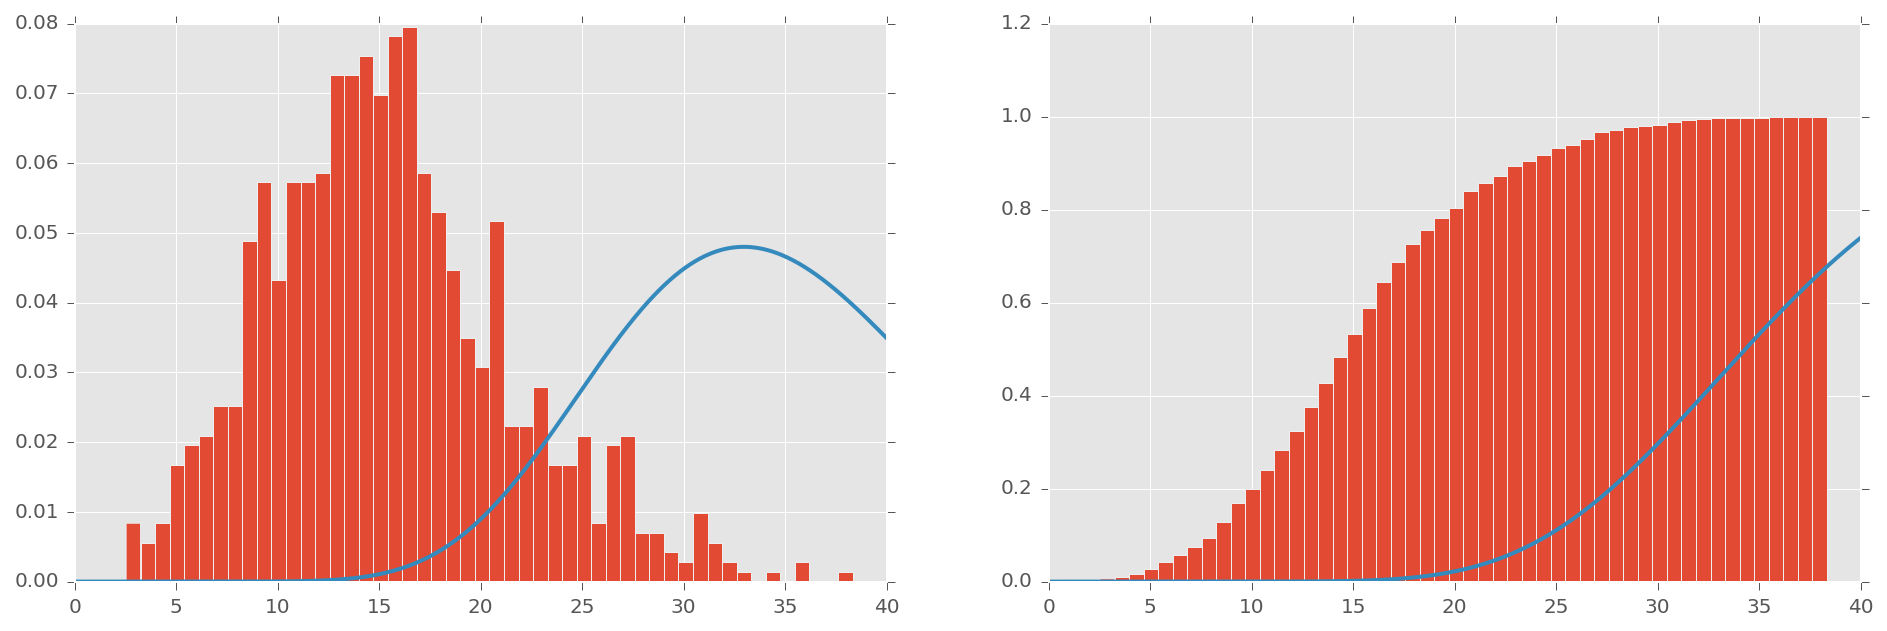

KstestResult(statistic=0.99999935542096663, pvalue=0.0)


In [30]:
from scipy.special import binom

pl.figure(0, figsize=(16, 5))
binomc = lambda m: np.array([binom(m, k) / 2**m for k in range(m + 1)])
ws = binomc(M)

test(rs, {M - k: w for k, w in enumerate(binomc(R))},
     bins=50)

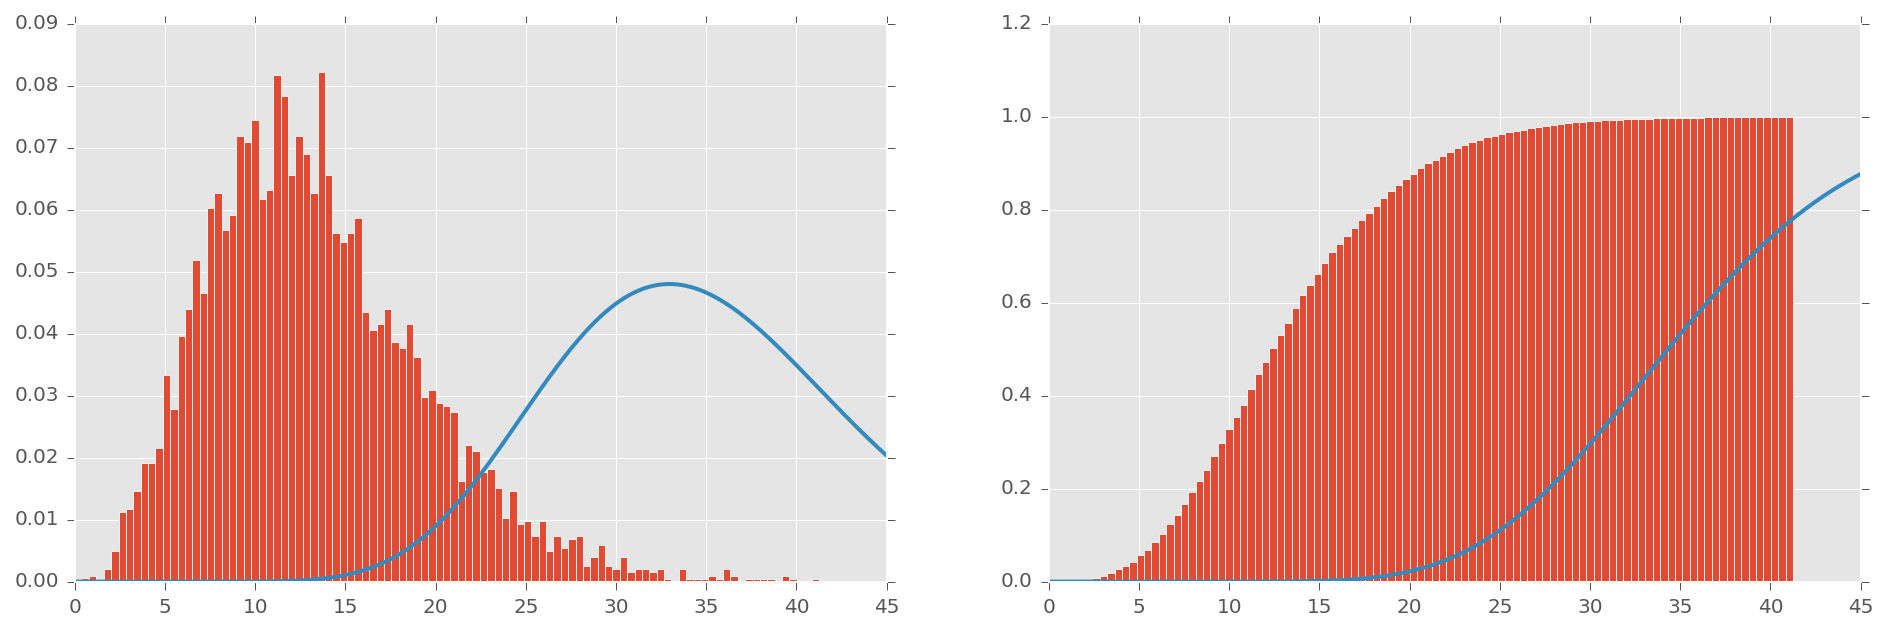

KstestResult(statistic=0.99999935542096663, pvalue=0.0)


In [17]:
from scipy.special import binom

pl.figure(0, figsize=(16, 5))
binomc = lambda m: np.array([binom(m, k) / 2**m for k in range(m + 1)])
ws = binomc(M)

test(rs, {M - k: w for k, w in enumerate(binomc(R))})

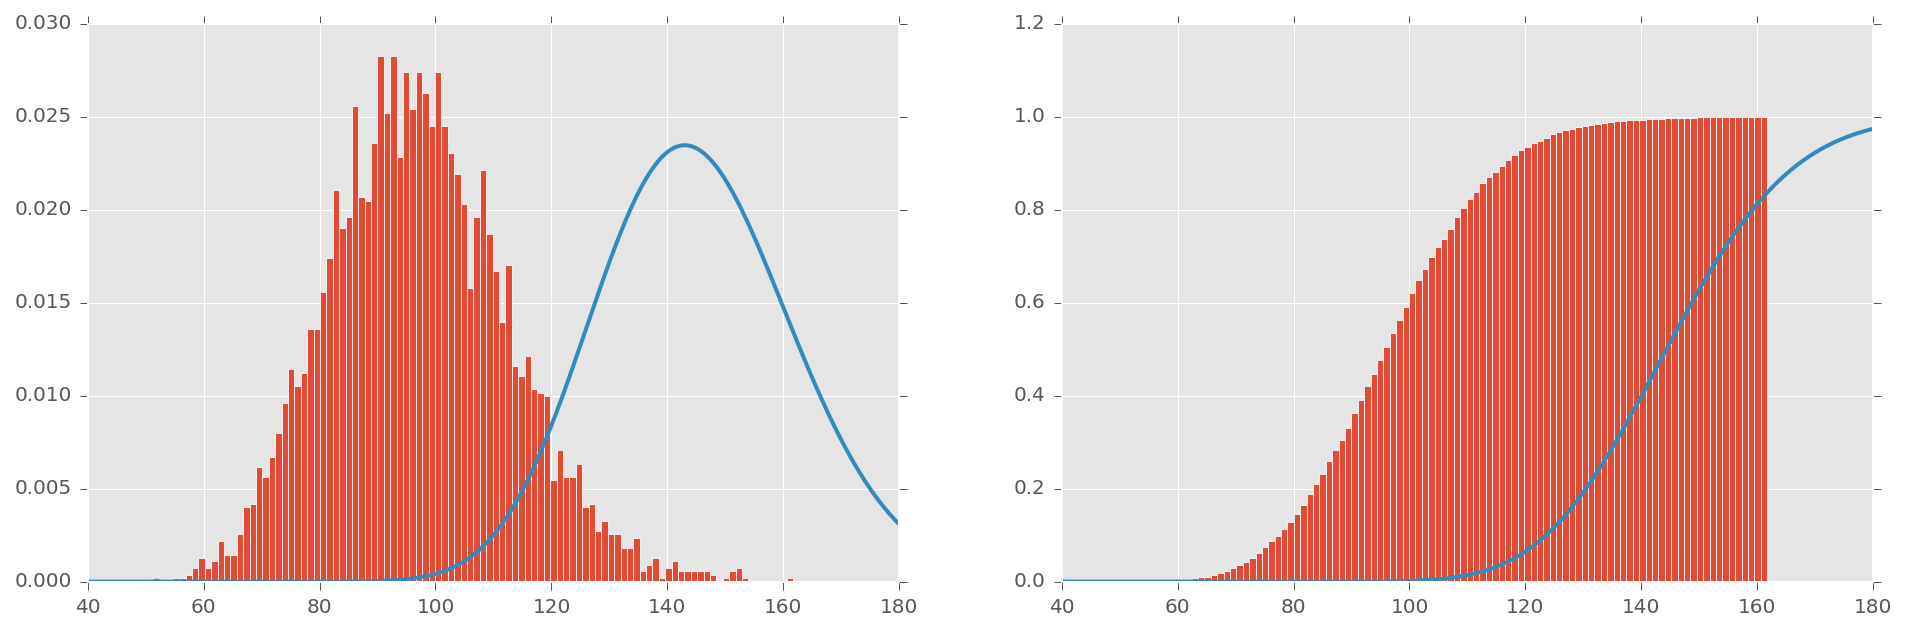

KstestResult(statistic=1.0, pvalue=0.0)


In [15]:
from scipy.special import binom

pl.figure(0, figsize=(16, 5))
binomc = lambda m: np.array([binom(m, k) / 2**m for k in range(m + 1)])
ws = binomc(M)

test(rs, {M - k: w for k, w in enumerate(binomc(R))})

In [46]:
model = {M - R - k: w for k, w in enumerate(binomc(M - R))}
pdf, cdf = model_to_f(model)

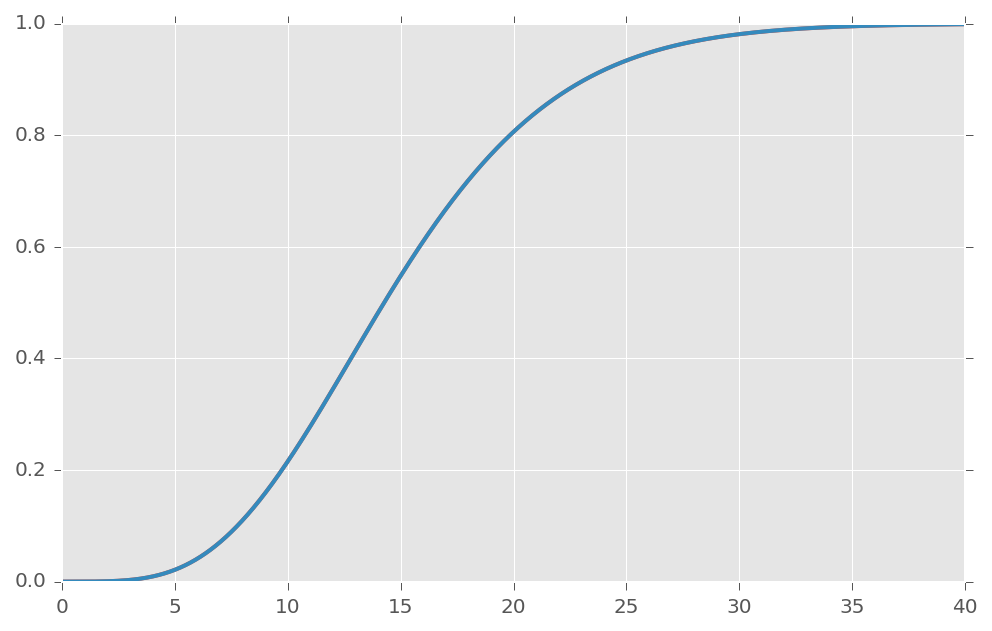

In [52]:
x = np.linspace(0, 40, 10000)[1:]
pl.plot(x, np.cumsum(pdf(x)) * 40 / 10000)
pl.plot(x, cdf(x))

array([             inf,   5.03791636e-07,   5.26209216e-07, ...,
         3.26118366e-04,   3.25730132e-04,   3.25342338e-04])